# 重要性采样 (Importance Sampling)

采样的一个重要目的是获得函数 $f(x)$ 在分布 $p(x)$ 上的期望值，即：$\mathbb{E}[f] = \int{f(x)p(x)}dx$。

通过对 $p(x)$ 采样可以得到近似值 $\mathbb{E}[f] \approx \frac{1}{L}\sum_{l=1}^{L}{f(x^{(l)})}$ 。

如果 $p(x)$ 不容易采样，一个替代方法就是对一个已知（容易）的分布 $q(x)$ 采样，然后根据 $p(x^{(l)})$ 和 $q(x^{(l)})$ 的比值调整每个样本的权重。

具体表达式是这样的：$\mathbb{E}[f] = \int{f(x)p(x)}dx = \int{f(x)\frac{p(x)}{q(x)}q(x)}dx \approx \frac{1}{L}\sum_{l=1}^{L}{\frac{p(x^{(l)})}{q(x^{(l)})}f(x^{(l)})}$，其中 $L$ 个样本是从 $q(x)$ 采样得出的。

其中 $r^{(l)}=\frac{p(x^{(l)})}{q(x^{(l)})}$ 是权重，体现了样本的重要性。

对于分布 $p(x) = \frac{\widetilde{p}(x)}{\int{\widetilde{p}(x)}dx} = \frac{\widetilde{p}(x)}{Z}$，如果 $Z$ 未知，期望值这样计算：$\mathbb{E}[f] \approx \sum_{l=1}^{L}{w_l f(x^{(l)})}$，
其中 $w_l = \frac{\widetilde{p}(x^{(l)}) \mathbin{/} q(x^{(l)})}{\sum_{m}{\widetilde{p}(x^{(m)}) \mathbin{/} q(x^{(m)})}}$ 。具体推导在最后。

## 例子

下面看看如何用重要性采样方法计算 $f(x) = \frac{x}{50}$ 在一个高斯混合分布 $\widetilde{p}(x)$ 上的期望值，$x$ 的取值范围是 $[0,10]$。$\widetilde{p}(x)$ 的具体定义是：$\widetilde{p}(x) = 0.3 * Normal(mean=4, sd=1) + 0.7 * Normal(mean=7, sd=0.5)$。

这里用到的 $q(x)$ 是 $Normal(mean=5, sd=2)$。

图示如下：

<img src="importance_sampling_overview.png" width=500>

对于直线 $f(x)=\frac{x}{50}$，如果 $x$ 是均匀分布，则在 $[0,10]$ 的范围内，$x$ 的期望值是平均值 $0.1$。但 $p(x)$ 在靠近 7 的位置密度较大，那相对与 $p(x)$ 的期望值估计要大于 0.1。

下面具体计算一下：

In [4]:
ptilde = function(x) {
    p = 0.3 * dnorm(x, mean=4, sd=1) + 0.7 * dnorm(x, mean=7, sd=0.5)
    return(p)
}

fx = function(x) {
    return(x/50)
}

n=10000
sample.x = rnorm(n, mean=5, sd=2)
r.l = ptilde(sample.x) / dnorm(sample.x, mean=5, sd=2)
w.l = r.l/sum(r.l)
exp.x = sum(w.l * fx(sample.x))
exp.x

[1] 0.1220014

确实大于 0.1，但是如何确定这个值是正确的呢？

下面用 Accept-Reject Sampling 方法从 $p(x)$ 中采样，然后估算 $f(x)$ 的期望值。

接受/拒绝采样中的提议分布 (proposal distribution) 是 $Normal(mean=7, sd=2)$。图示如下：

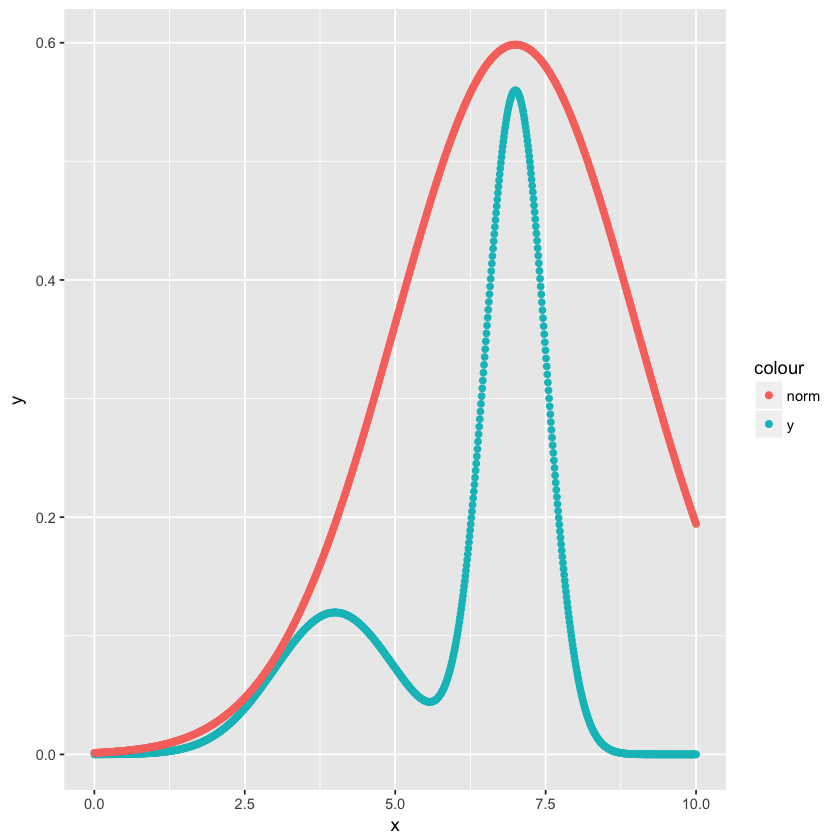

In [7]:
library(ggplot2)
x=seq(0,10,length=1000)
df = data.frame(x=x, y=ptilde(x), norm=3*dnorm(x, mean=7, sd=2))
ggplot(df, color=variable)+geom_point(aes(x,y, col='y'))+geom_point(aes(x,y=norm, col='norm'))

接受/拒绝的采样过程：

In [17]:
n=50000
zs=c()
us=c()
for (i in seq(0,1,length=n)) {
    zi = rnorm(1, mean=7, sd=2)
    q  = 3 * dnorm(zi, mean=7, sd=2)
    u  = runif(1, min=0, max=q)
    if (u > ptilde(zi))
        next
    zs = append(zs, zi)
    us = append(us, u)
}
length(zs)

[1] 16798

采样的结果，直方图：

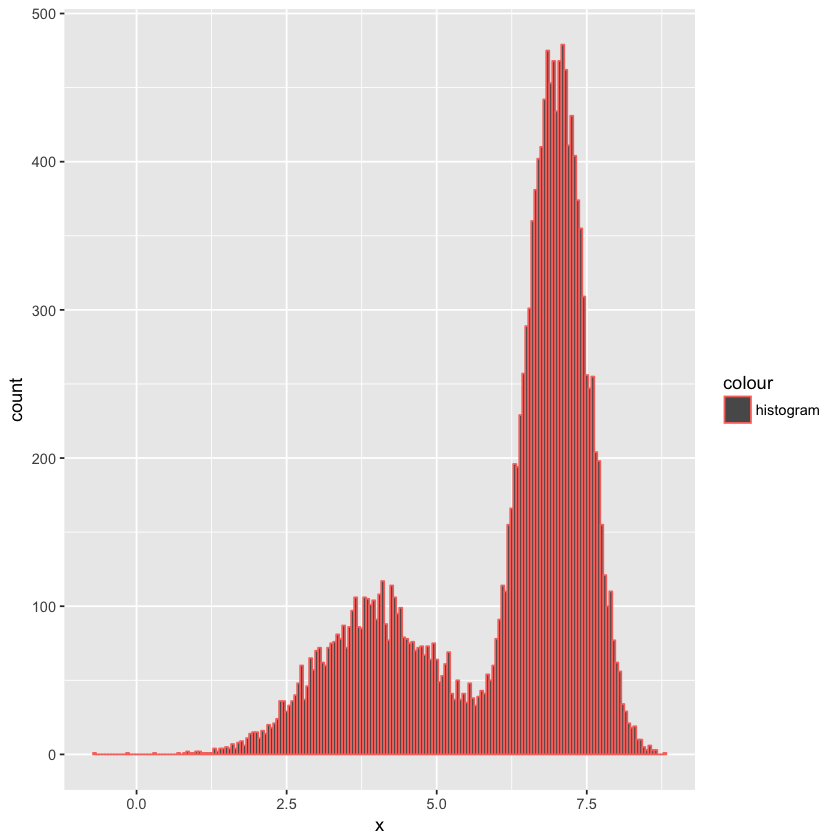

In [22]:
ggplot(data.frame(x=zs), color=variable) + geom_histogram(mapping=aes(x, col='histogram'), binwidth=0.05)

可以看出是大致符合上面定义的高斯混合分布。

下面针对这些样本计算 $f(x)$ 的期望值：

In [18]:
sum(fx(zs))/length(zs)

[1] 0.1221386

与上面通过 Importance Sampling 计算出的值基本吻合。

## 重要性重采样

上面针对 $p(x)$ 计算了 $f(x)$ 的期望值，但是这个方法也可以用来对 $p(x)$ 采样。

步骤是：

1. 从 q(x) 采样 L 个样本
1. 计算每个样本的权重 $w_l$ （计算方法见上一节）
1. 根据权重 $w_l$ 再从上面的 L 个样本中采样出 L 个样本（当然有重复）

最后得出的 L 个样本将符合 $p(x)$ 分布。由于最后一步从已有的样本中采样，所以叫重采样。

下面看看效果。

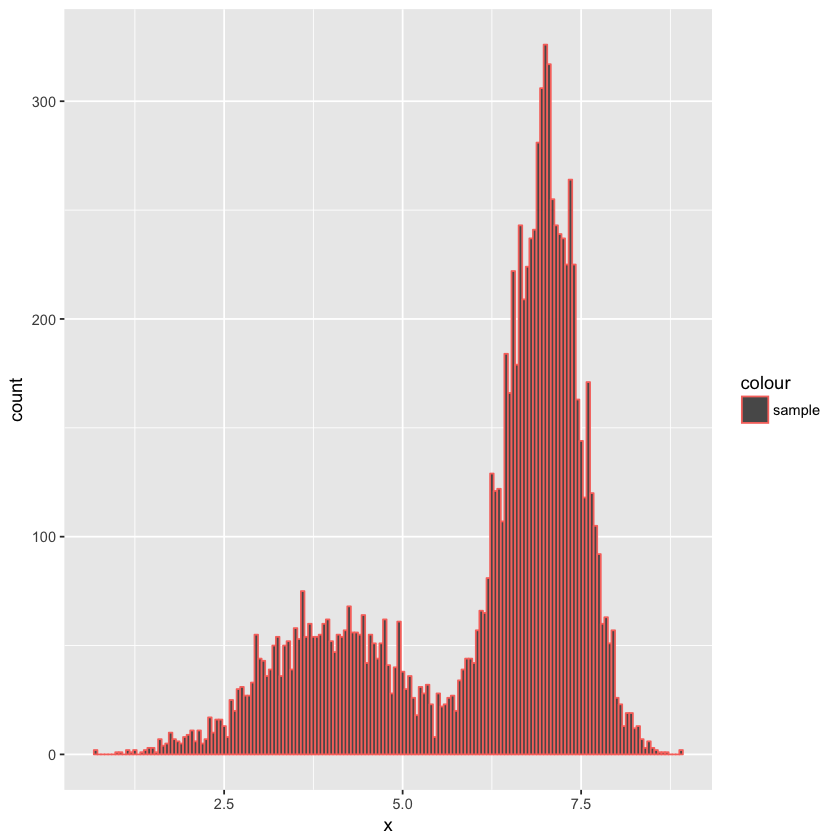

In [25]:
df = data.frame(x=sample(sample.x, length(sample.x), replace=T, prob=w.l))
ggplot(df, color=variable)+geom_histogram(aes(x, col='sample'), binwidth=0.05)

也是大致符合目标分布。

## 权重计算公式的推导

参考自 [PRML](https://www.amazon.com/Pattern-Recognition-Learning-Information-Statistics/dp/0387310738) 11.1.5。

设 $p(x) = \frac{\widetilde{p}(x)}{Z_p}$ 和 $q(x) = \frac{\widetilde{q}(x)}{Z_q}$。

\begin{align}
\mathbb{E}[f] = \int{f(x)p(x)}dx
              = \frac{Z_q}{Z_p}\int{f(x)\frac{\widetilde{p}(x)}{\widetilde{q}(x)}q(x)}dx
              \approx \frac{Z_q}{Z_p}\frac{1}{L}\sum_{l=1}^{L}{\widetilde{r}_l}f(x^{(l)})
\end{align}

其中，$\widetilde{r}_l = \frac{\widetilde{p}(x^{(l)})}{\widetilde{q}(x^{(l)})}$ 。

\begin{align}
\frac{Z_p}{Z_q} = \frac{1}{Z_q}\int{\widetilde{p}(x)}dx = \int{\frac{\widetilde{p}(x)}{\widetilde{q}(x)}q(x)}dx
                \approx \frac{1}{L}\sum_{l=1}^{L}\widetilde{r}_l
\end{align}

\begin{align}
\frac{Z_q}{Z_p} = L \times \frac{1}{\sum_{l=1}^{L}\widetilde{r}_l}
\end{align}

带入期望值的公式：$\mathbb{E}[f] \approx \sum_{l=1}^{L}{ \frac{\widetilde{r}_l}{\sum_{m}{\widetilde{r}_m}}f(x^{(l)}) } = \sum_{l=1}^{L}{ w_l f(x^{(l)}) }$。

其中 $w_l = \frac{\widetilde{r}_l}{\sum_{m}{\widetilde{r}_m}} = \frac{\widetilde{p}(x^{(l)}) \mathbin{/} q(x^{(l)})}{\sum_{m}{\widetilde{p}(x^{(m)}) \mathbin{/} q(x^{(m)})}}$ （$Z_q$可以被消掉）。

## 其他

重要性采样在图模型（Graph Model）中有较多应用，以后在碰到图模型的时候再讨论。